# Internship in the analytical department of Yandex.Afisha.

# Project Description

You have demonstrated outstanding performance during your participation in the TripleTen course. As a result, you have been offered an opportunity to undergo an internship program in the analytics department of **Y.Afisha** company. Your first task is to assist in optimizing the marketing budget.

You are equipped with:
- Server logs containing website visit data to Y.Afisha from January 2017 to December 2018.
- Data dump containing all orders for that period.
- Marketing cost statistics.

You will learn:
- How users utilize Y.Afisha products.
- When they start making purchases.
- The amount of money contributed by each user.
- When all marketing costs are recovered.

# Data Description

1. Table **visits** (server log containing website visit data):
- *Uid*: User ID
- *Device*: User device
- *Start Ts*: Start date and time of the session
- *End Ts*: End date and time of the session
- *Source Id*: Ad source ID, the source used by the user to come to the website

All dates in this table are in YYYY-MM-DD format.

2. Table **orders** (order-related data):

- *Uid*: User ID who placed the order
- *Buy Ts*: Date and time the order was placed
- *Revenue*: Y.Afisha's revenue from the order

3. Table **costs** (marketing expense-related data):
- *source_id*: Ad source ID
- *dt*: Date
- *costs*: Expenses for the ad source on that date

## Step 1: Download and Prepare Data for Analysis

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

pd.options.display.float_format = "{:.2f}".format

Here will save `visits`, `orders`, and `costs` data into variables. Optimize the data for analysis purposes. Ensure that all columns have the correct data types.

In [2]:
visits_path = '/datasets/visits_log_us.csv'
orders_path = '/datasets/orders_log_us.csv'
costs_path = '/datasets/costs_us.csv' 

visits = pd.read_csv(visits_path, nrows = 500)
orders = pd.read_csv(orders_path, nrows = 500)
costs = pd.read_csv(costs_path, nrows = 500)

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 19.7+ KB


We will do some update on dataframe `visits`:
- Check the data content in the 'device' column to change its data type, if possible
- Convert `Start Ts` and `End Ts` columns to the DateTime type

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   500 non-null    object 
 1   Revenue  500 non-null    float64
 2   Uid      500 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 11.8+ KB


From the information we got, we need to update:
- Convert `Buy_Ts` column to the DateTime type

In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  500 non-null    int64  
 1   dt         500 non-null    object 
 2   costs      500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


From the information we got, we need to update:
- Convert `dt` column to the DateTime type

### Loading data in an optimized form

On this stage we are going to do:
- Convert date columns from dataframe `visits`, `orders`, and `costs` to the DateTime type.

In [6]:
visits = pd.read_csv(visits_path,  
         dtype={'Device': 'category'},
         parse_dates=['Start Ts', 'End Ts'])
orders = pd.read_csv(orders_path,
         parse_dates=['Buy Ts']
         )
costs = pd.read_csv(costs_path,
        parse_dates=['dt']
        )

### Data Pre-processing

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [8]:
visits.duplicated().sum()

0

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [10]:
orders.duplicated().sum()

0

In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [12]:
costs.duplicated().sum()

0

**Conclusion:**
- The data type of dataFrame `visits`, `orders`, and `costs` were already suitable.
- No missing data were found.
- No duplicated data were found.
- We need to change the column names to all lowercase, and also to replace `' '` to `'_'` in the column names.

In [13]:
visits = visits.rename(columns = {'End Ts':'End_Ts', 'Source Id':'Source_Id', 'Start Ts':'Start_Ts'})
visits = visits.rename(str.lower, axis = 'columns')
orders = orders.rename(columns = {'Buy Ts':'Buy_Ts'})
orders = orders.rename(str.lower, axis = 'columns')

In [14]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


All is successfully done

## Step 2:  Create a Report and Calculate Required Metrics

### Product Metrics

We will calculate the products metrics based on these components:
- How many people use the product each day, week, and month?
- How many sessions per day? (A single user may have more than one session).
- What is the duration of each session?
- How often do users return to using the product?

#### How many people use the product each day, week, and month?

In [16]:
visits['day'] = visits['start_ts'].dt.day
visits['week'] = visits['start_ts'].dt.isocalendar().week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year

dau = visits.groupby(['day', 'month', 'year']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['week', 'year']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['month', 'year']).agg({'uid':'nunique'}).mean()

print('{:} people use the app every day.'.format(int(dau)))
print('{:} people use the app every week.'.format(int(wau)))
print('{:} people use the app every month'.format(int(mau)))

907 people use the app every day.
5716 people use the app every week.
23228 people use the app every month


It's time to plot the graph

In [17]:
# Let's prepare to plot DAU
dau_graph = visits.groupby(['year', 'month', 'day']).agg({'uid':'nunique'})
dau_graph = dau_graph.reset_index()

dau_graph['month'] = dau_graph['month'].astype('string')
dau_graph['year'] = dau_graph['year'].astype('string')

dau_graph['xticks'] = dau_graph['month'] + '-' + dau_graph['year']

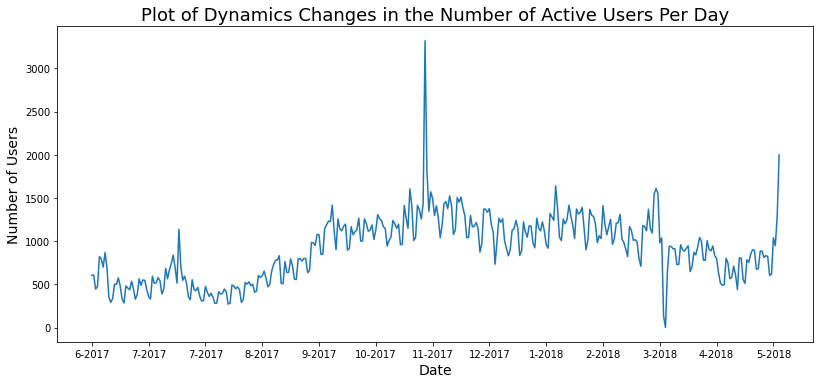

In [18]:
# Let's plot DAU Graph
fig, ax = plt.subplots(figsize=(15, 6))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(dau_graph['uid'])
x_pos = np.arange(len(dau_graph['uid']))
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Users', fontsize=14)
ax.set_title('Plot of Dynamics Changes in the Number of Active Users Per Day', fontsize=18)
plt.xticks(x_pos,dau_graph['xticks'])
loc = ticker.MultipleLocator(base=30) 
ax.xaxis.set_major_locator(loc)

plt.show()

**Insights:**

The graph reveals weekly fluctuations, which means that the number of users on different days of the week varies. As we can see it, the number of unique users has been growing since July 2017, it has peak in November, but it stops afterwards and initiates a gradual decline.

In [19]:
# Let's prepare to plot MAU
mau_graph = visits.groupby(['year','month']).agg({'uid':'nunique'})
mau_graph = mau_graph.reset_index()

mau_graph['month'] = mau_graph['month'].astype('string')
mau_graph['year'] = mau_graph['year'].astype('string')

mau_graph['xticks'] = mau_graph['month'] + '-' + mau_graph['year']

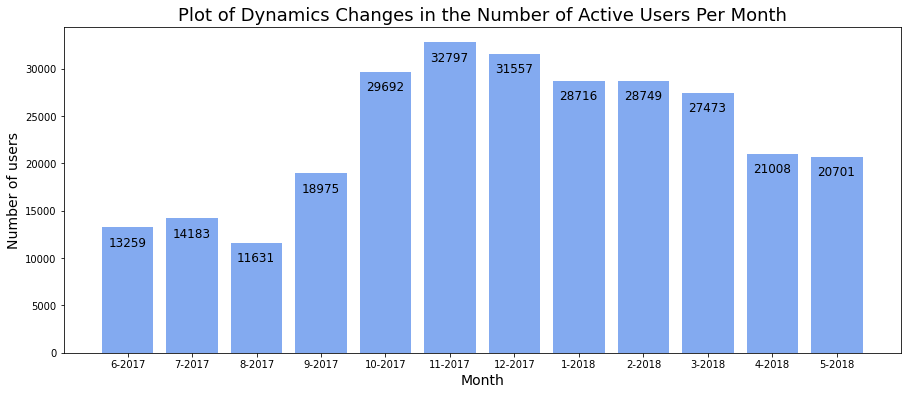

In [20]:
# Calculate the number of data points (months) and create an index array
n = len(mau_graph['xticks'])
ind = np.arange(n) 

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the data as a bar chart
plt.bar(ind, mau_graph['uid'],
        align='center',
        alpha=0.8, 
        color='cornflowerblue')

# Set labels and title for the graph
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of users', fontsize=14)
plt.title('Plot of Dynamics Changes in the Number of Active Users Per Month', fontsize=18)

# Set x-axis tick labels
plt.xticks(ind, mau_graph['xticks'])

# Add data values as text above the bars
for idx, i in enumerate(ax.patches):
    ax.text(i.get_x() + 0.1, 
            i.get_height() - 2000, 
            int(mau_graph['uid'][idx]), 
            fontsize=12,
            color='black')

# Display the plot
plt.show()


**Insights:**

The graph reveals the number of users initiate to increase significantly in October 2017. The minimum number of users is observed in August 2017. From August to November, the number of users triples.

##### Sticky factor

In [21]:
sticky_factor_weekly = dau/wau*100
sticky_factor_monthly = dau/mau*100
print('DAU/WAU is {:.2f}.'.format(sticky_factor_weekly[0]))
print('DAU/MAU is {:.2f}.'.format(sticky_factor_monthly[0]))

DAU/WAU is 15.88.
DAU/MAU is 3.91.


Let's build graphs for deep analysis.

#####  Graph 1. Sticky factor (DAU/MAU and DAU)

In [22]:
visits['date'] = visits['start_ts'].dt.floor('1D')
min_date = visits['date'].min() # date of first visit

dau_all_term = visits.groupby(['date']).agg({'uid':'nunique'})
dau_all_term = dau_all_term.reset_index()

For a consistent measurement, we will skip all of data on the first 30 days

In [23]:
def sticky_factor(listed):
    # We will skip the first 30 days so that we can calculate the data for the first month
    if int((listed - min_date) / np.timedelta64(1, 'D'))> 29:
        dau_day_x = dau_all_term[dau_all_term['date'] == listed]['uid'].min()
        maintime = listed - pd.Timedelta(days=30)
        
        mau_day_x = visits.query('date <= @listed and date > @maintime')['uid'].nunique()
        return dau_day_x / mau_day_x*100
    else:
        return 0
    
dau_all_term['sticky_factor'] = (
    dau_all_term['date'].apply(sticky_factor)
)

Let's build a graph

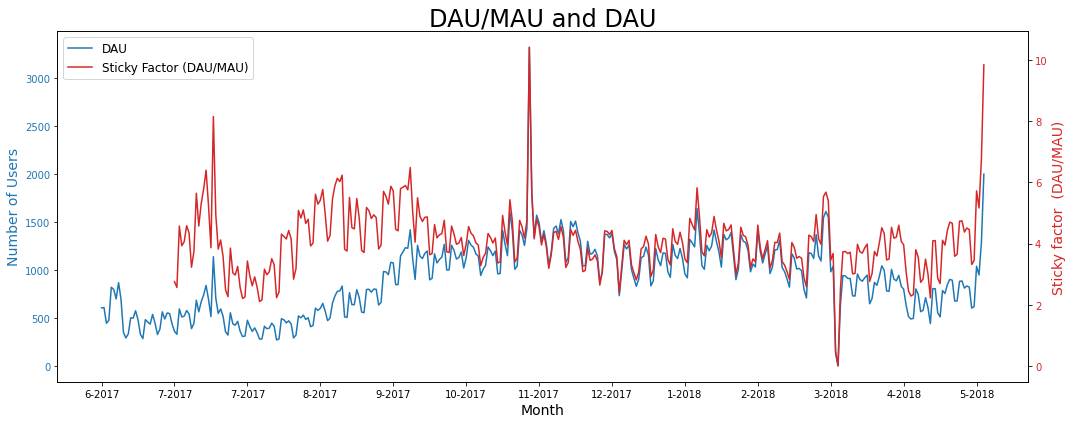

In [24]:
# graph 1. Sticky factor  (DAU/MAU and DAU)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot the first dataset (DAU) and specify color
color_ax1 = 'tab:blue'
plt.plot(dau_graph['uid'], color=color_ax1, label='DAU')


# Set labels and title for the first graph
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Users', fontsize=14, color=color_ax1)
plt.tick_params(axis='y', labelcolor=color_ax1)
plt.title('DAU/MAU and DAU', fontsize=24)
plt.xticks(np.arange(len(dau_graph['uid'])), dau_graph['xticks'])

# Set major tick locator to show every 30 days
loc = ticker.MultipleLocator(base=30)
ax1.xaxis.set_major_locator(loc)

# Create a second y-axis on the right
ax2 = ax1.twinx()

# Plot the second dataset (Sticky Factor) and specify color
color_ax2 = 'tab:red'
ax2.plot(dau_all_term.query('sticky_factor > 0')['sticky_factor'], color=color_ax2, label='Sticky Factor (DAU/MAU)')

# Set labels for the second y-axis
ax2.set_ylabel('Sticky factor  (DAU/MAU)', color=color_ax2, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color_ax2)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left', fontsize=12)

# Ensure the layout is tight
fig.tight_layout()

# Display the plot
plt.show()


**Conclusion:**

As evident from our observations, starting from August 2017, our charts gradually came closer together, implying a reduced frequency of user engagement with our service. This trend persisted since October, with the charts displaying consistent dynamics, signifying a halt in the decline of interest in our service. Interestingly, in March 2018, the "sticky factor" began to show a more pronounced growth compared to DAU, indicating that users were becoming more frequent users of our service, which is certainly positive news.

##### Graph 2. Sticky factor (DAU/MAU and MAU)

In [25]:
dau_all_term['month'] = dau_all_term['date'].dt.month
dau_all_term['year'] = dau_all_term['date'].dt.year
dau_all_term['month'] = dau_all_term['month'].astype('string')
dau_all_term['year'] = dau_all_term['year'].astype('string')

dau_all_term['xticks'] = dau_all_term['month'] + '-' + dau_all_term['year']
dau_month = dau_all_term.groupby('xticks').agg({'sticky_factor':'mean'})
dau_month = dau_month.reset_index()
mau_graph = mau_graph.merge(dau_month, on = 'xticks')
pattern = mau_graph

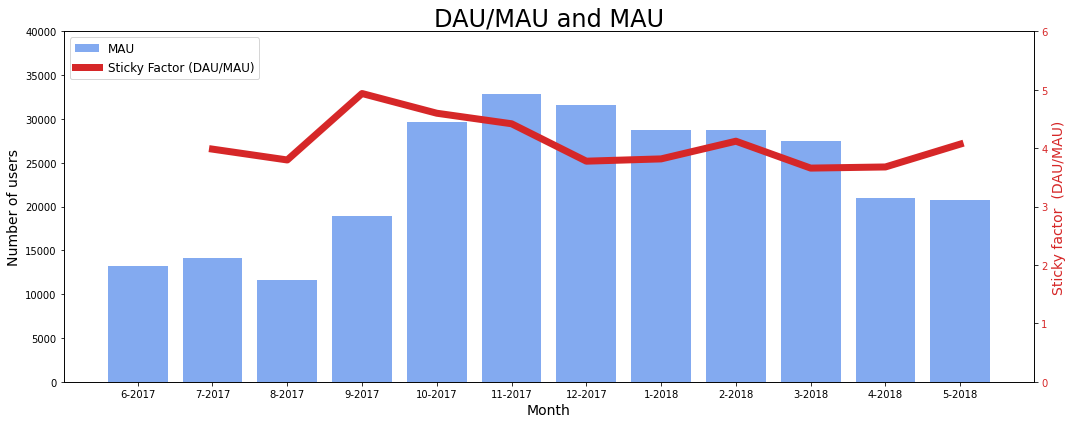

In [26]:

# Sample data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)
n = len(mau_graph['xticks'])
ind = np.arange(n)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot the first dataset with a label
ax1.bar(ind, mau_graph['uid'],
        align='center',
        alpha=0.8, 
        color='cornflowerblue',
        label='MAU')  # Add label for the first dataset



# Set labels and title
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of users', fontsize=14)
plt.title('DAU/MAU and MAU', fontsize=24)
plt.xticks(ind, mau_graph['xticks'])

# Set the y-axis limits for the first axis
ax1.set_ylim([0, 40000])

# Create a second y-axis on the right
ax2 = ax1.twinx()

# Plot the sticky factor data and specify a label
color = 'tab:red'
ax2.plot(mau_graph.query('sticky_factor > 0')['sticky_factor'], color=color, linewidth=7.0, label='Sticky Factor (DAU/MAU)')

# Set labels and y-axis limits for the second axis
ax2.set_ylabel('Sticky factor  (DAU/MAU)', color=color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 6])

# Add a legend to the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left', fontsize=12)

# Ensure the layout is tight
fig.tight_layout()

# Display the plot
plt.show()


From the illustrated graph we find some conclusion:
- The graph illustrates a notable trend in the sticky factor over time in comparison to the Monthly Active Users (MAU). For the initial four months, the sticky factor closely mirrored the behavior of MAU, suggesting that the proportion of daily users remained relatively stable. However, following this period, the sticky factor exhibited a decline, while MAU maintained a steady level from October 2017 to March 2018.
- This divergence indicates that although the monthly user count remained consistent, users began using the service less frequently on a daily basis. The decline continued until January 2018, at which point a reversal occurred, with the sticky factor showing an upward trend. This reversal signifies that users have started to engage with the service more frequently, which is a positive development.

#### The number of sessions per day

In [27]:
# Group the 'visits' DataFrame by year, month, and day, and aggregate the 'uid' column to count sessions per day.      
sessions_per_day   = visits.groupby(['year','month','day']).agg({'uid':'count'})

# Rename the 'uid' column to 'count_sessions' for clarity.
sessions_per_day   = sessions_per_day.rename(columns = {'uid':'count_sessions'})

# Print the average number of sessions per day.
# Calculate the average number of sessions per day using the 'mean()' function and convert it to an integer.
print('Average number of sessions per day - {:}'.format(int(sessions_per_day.mean())))

Average number of sessions per day - 987


##### Comparison of the total number of sessions per day with the DAU.

In [28]:
sessions_per_day = sessions_per_day.reset_index().reset_index()
dau_graph = dau_graph.reset_index()

In [29]:
# Merge the 'dau_graph' DataFrame with the 'sessions_per_day' DataFrame using the 'index' column as the common key.
dau_graph = dau_graph.merge(sessions_per_day, on='index')

# Select specific columns ('index', 'xticks', 'uid', 'count_sessions') from the merged DataFrame.
dau_graph = dau_graph[['index', 'xticks', 'uid', 'count_sessions']]

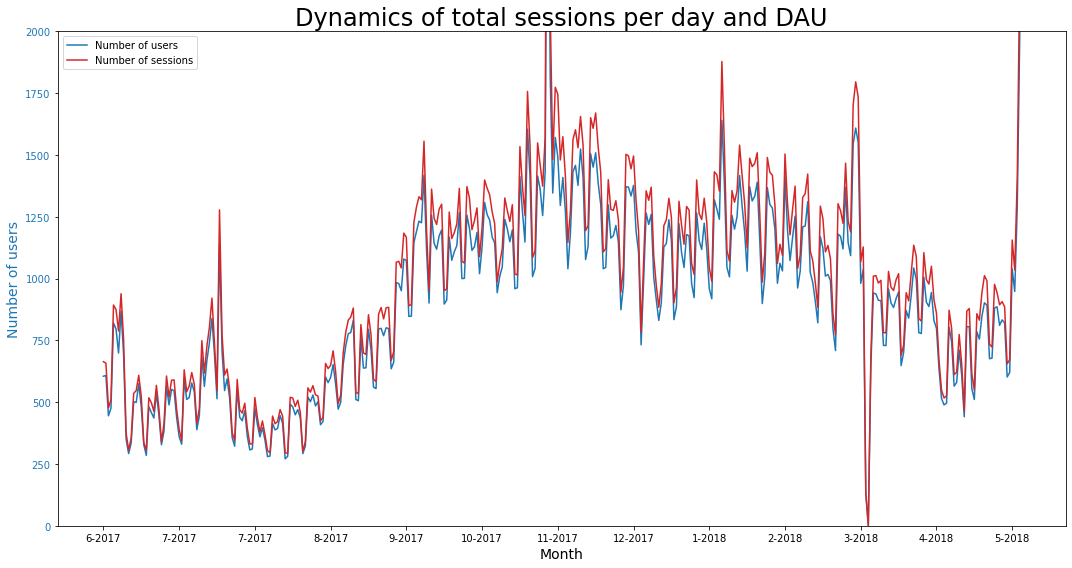

In [30]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Specify colors for the two lines
color_ax1 = 'tab:blue'  # Color for the 'Number of users' line
color_ax2 = 'tab:red'   # Color for the 'Number of sessions' line

# Plot the 'Number of users' and 'Number of sessions' lines
plt.plot(dau_graph['uid'], color=color_ax1)
plt.plot(dau_graph['count_sessions'], color=color_ax2)

# Create an array of x positions for x-axis ticks
x_pos = np.arange(len(dau_graph['uid']))


# Set labels, title, and tick parameters
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of users', fontsize=14, color=color_ax1)
plt.tick_params(axis='y', labelcolor=color_ax1)
plt.title('Dynamics of total sessions per day and DAU', fontsize=24)
plt.xticks(x_pos, dau_graph['xticks'])

# Set the major tick locator to show every 30 days on the x-axis
loc = ticker.MultipleLocator(base=30) 
ax1.xaxis.set_major_locator(loc)

# Set the y-axis limit for the 'Number of users' line
ax1.set_ylim([0, 2000])

# Add a legend to distinguish the two lines
plt.legend(["Number of users", "Number of sessions"])

# Ensure the layout is tight
fig.tight_layout()

# Display the plot
plt.show()


**Conclusion:**

It's noticeable that the "Number of sessions" chart consistently stays slightly ahead of the DAU chart. However, this lead is quite small, indicating that it's very rarely for users to use the service multiple times within a single day.

##### The average number of sessions per user.

In [31]:
# Create a new column called 'number_sessions_per_user' in the 'dau_graph' DataFrame.
# This column calculates the ratio of 'count_sessions' (number of sessions) to 'uid' (number of users) for each month.
dau_graph['number_sessions_per_user'] = dau_graph['count_sessions']/dau_graph['uid']

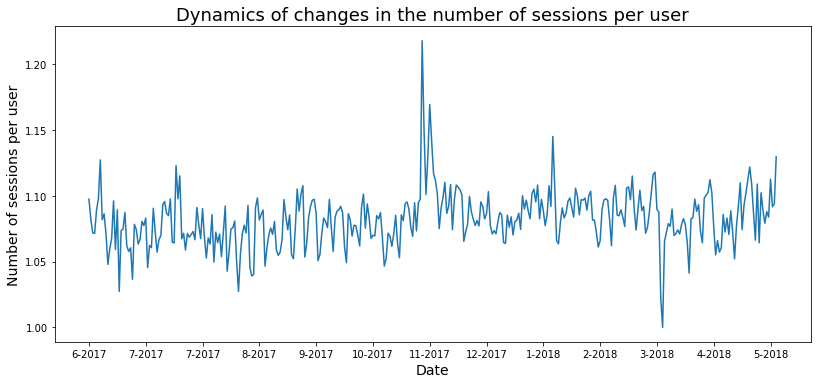

In [32]:
# Create a figure and axis with specified figure size and adjustments
fig, ax = plt.subplots(figsize=(15, 6))
fig.subplots_adjust(bottom=0.15, left=0.2)

# Plot the 'number_sessions_per_user' data
ax.plot(dau_graph['number_sessions_per_user'])

# Create an array of x positions for x-axis ticks
x_pos = np.arange(len(dau_graph['number_sessions_per_user']))

# Set x-axis label, y-axis label, and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of sessions per user', fontsize=14)
ax.set_title('Dynamics of changes in the number of sessions per user', fontsize=18)

# Set x-axis ticks and major tick locator to show every 30 days
plt.xticks(x_pos, dau_graph['xticks'])
loc = ticker.MultipleLocator(base=30)
ax.xaxis.set_major_locator(loc)

# Display the plot
plt.show()

**Conclusion:**

As we can see it, throughout the entire time we've observed, the number of sessions per user has consistently ranged from 1.05 to 1.15. This suggests that most users don't feel the need to use our service multiple times in a single day.

##### Distribution of sessions by device type.

In [33]:
visits['device'].unique()

['touch', 'desktop']
Categories (2, object): ['touch', 'desktop']

In [34]:
touch_sessions = (
    visits[visits['device'] == 'touch']
    .groupby(['year', 'month', 'day'])
    .agg({'uid': 'count'})
    .reset_index()
)

# Rename the 'uid' column to 'count_sessions' for clarity.
touch_sessions = touch_sessions.rename(columns={'uid': 'count_sessions'})

# Calculate the number of sessions for the 'desktop' device and group the data by year, month, and day.
desktop_sessions = (
    visits[visits['device'] == 'desktop']
    .groupby(['year', 'month', 'day'])
    .agg({'uid': 'count'})
    .reset_index()
)

# Rename the 'uid' column to 'count_sessions' for clarity.
desktop_sessions = desktop_sessions.rename(columns={'uid': 'count_sessions'})
desktop_sessions

,year,month,day,count_sessions
0,2017,6,1,501
1,2017,6,2,498
2,2017,6,3,329
3,2017,6,4,349
4,2017,6,5,693
...,...,...,...,...
359,2018,5,27,426
360,2018,5,28,835
361,2018,5,29,751
362,2018,5,30,989


In [35]:
desktop_sessions = desktop_sessions.rename(columns = {'count_sessions':'column_name_desktop'})
desktop_sessions['date'] = desktop_sessions['day'].astype('string') + '-' + desktop_sessions['month'].astype('string') + '-' + desktop_sessions['year'].astype('string')
touch_sessions   = touch_sessions.rename(columns = {'count_sessions':'column_name_touch'})
touch_sessions['date'] = touch_sessions['day'].astype('string') + '-' + touch_sessions['month'].astype('string') + '-' + touch_sessions['year'].astype('string')
desktop_sessions = desktop_sessions.merge(touch_sessions, on = 'date')
desktop_sessions['xticks'] = desktop_sessions['month_y'].astype('string') + '-' + desktop_sessions['year_y'].astype('string')
desktop_sessions

,year_x,month_x,day_x,column_name_desktop,date,year_y,month_y,day_y,column_name_touch,xticks
0,2017,6,1,501,1-6-2017,2017,6,1,163,6-2017
1,2017,6,2,498,2-6-2017,2017,6,2,160,6-2017
2,2017,6,3,329,3-6-2017,2017,6,3,148,6-2017
3,2017,6,4,349,4-6-2017,2017,6,4,161,6-2017
4,2017,6,5,693,5-6-2017,2017,6,5,200,6-2017
...,...,...,...,...,...,...,...,...,...,...
358,2018,5,27,426,27-5-2018,2018,5,27,246,5-2018
359,2018,5,28,835,28-5-2018,2018,5,28,321,5-2018
360,2018,5,29,751,29-5-2018,2018,5,29,284,5-2018
361,2018,5,30,989,30-5-2018,2018,5,30,421,5-2018


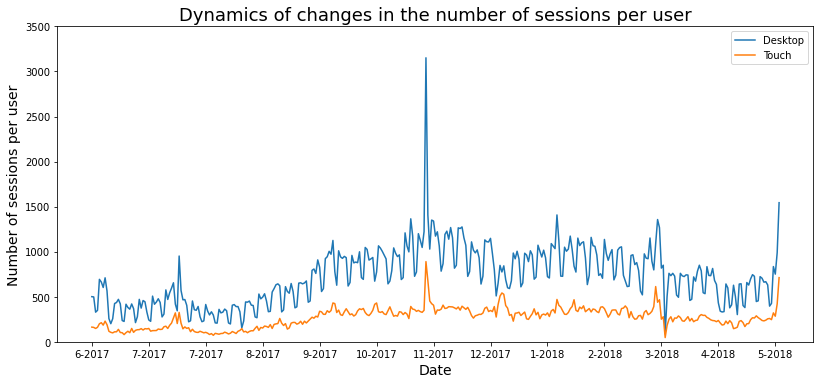

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(desktop_sessions['column_name_desktop'])
ax.plot(desktop_sessions['column_name_touch'])
x_pos = np.arange(len(desktop_sessions['column_name_touch']))
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of sessions per user', fontsize=14)
ax.set_title('Dynamics of changes in the number of sessions per user', fontsize=18)

plt.xticks(x_pos,desktop_sessions['xticks'])
loc = ticker.MultipleLocator(base=30) 
ax.xaxis.set_major_locator(loc)
ax.set_ylim([0, 3500])
plt.legend(["Desktop", "Touch"])
plt.show()

**Conclusion:**

The graph clearly illustrates that our service is utilized approximately three times more frequently on personal computers compared to mobile devices. Additionally, it highlights a usage pattern where mobile phone users engage with our services consistently throughout the week, whereas PC users exhibit a noticeable decrease in sessions during the weekends. This difference can be attributed to the convenience of having a mobile phone accessible at all times, while PC usage is often associated with work-related activities.

#### The duration of each session.

In [37]:
# Calculate the session duration in seconds by subtracting the 'start_ts' from the 'end_ts' columns,
# and then extracting the seconds component using .dt.seconds.
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

# Generate a descriptive summary of the 'session_duration_sec' column using .describe().
visits['session_duration_sec'].describe()

count   359400.00
mean       643.51
std       1016.33
min          0.00
25%        120.00
50%        300.00
75%        840.00
max      84480.00
Name: session_duration_sec, dtype: float64

Since the average and median value of the session duration are significantly different, we will use median to determine the session duration value. 

The median session duration: 300.0 secs


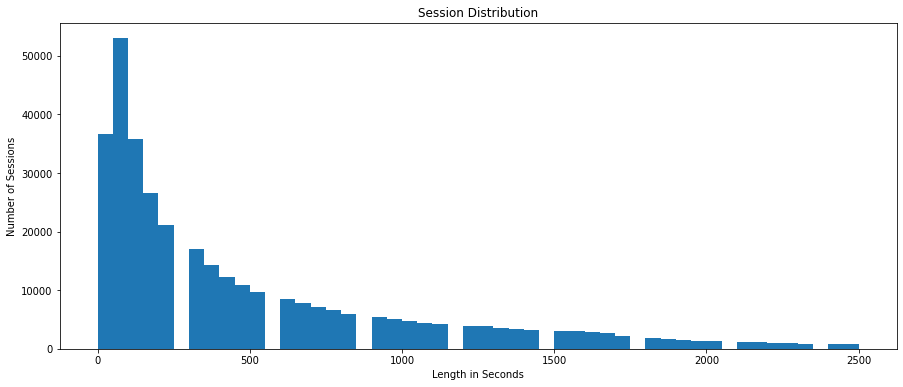

In [38]:
# Calculate the median session duration in seconds and round it to two decimal places.
length_per_session = visits['session_duration_sec'].median()
print("The median session duration: " + str(length_per_session.round(decimals=2)) + " secs")

# Plotting a histogram to visualize the distribution of session durations.
fig, ax = plt.subplots(figsize=(15, 6))

plt.hist(visits['session_duration_sec'], range=[0, 2500], bins=50)
plt.title('Session Distribution')
plt.xlabel('Length in Seconds')
plt.ylabel('Number of Sessions')
plt.show()

In [39]:
visit_avg_length = visits['session_duration_sec'].median()
print('The average session duration is {:.0f} seconds'.format(visit_avg_length))
freq = visits['session_duration_sec'].mode()

duration_zero = len(visits.query('session_duration_sec == 0'))
print('Most often the session lasted', freq[0], ' seconds.')
print(duration_zero, ' sessions of 0 seconds.')


The average session duration is 300 seconds
Most often the session lasted 60  seconds.
35794  sessions of 0 seconds.


**Conclusion:**

The average session duration is 5 minutes (300 seconds). In most cases, sessions were as short as 1 minute (60 seconds).

We've identified 35,794 sessions with a 0-second duration, indicating that users faced connection issues preventing them from using our service. These issues could originate from the user's end, like poor internet connectivity, or from our end, such as server problems.

#### How often do users come back?

In [40]:
# Create a copy of the 'visits' DataFrame to work with
visits_retention = visits

# Define a function to find the first session date for each user
def find_first_session(df, name_column, activity_type='first_session'):
    # Group the DataFrame by 'uid' and find the minimum date for the specified 'name_column'
    visits_first = df.groupby(['uid']).agg({name_column: 'min'})
    
    # Rename the 'name_column' to 'activity_type' for clarity
    visits_first = visits_first.rename(columns={name_column: activity_type})
    
    # Merge the 'visits_first' DataFrame with the original DataFrame ('df') on the 'uid' column
    df = df.merge(visits_first, on='uid')
    
    # Round the 'activity_type' date to the nearest day
    df[activity_type] = df[activity_type].dt.floor('1D')
    
    return df


In [41]:
# Define a function to find the beginning of the month for each session in the DataFrame
def find_beginning_of_month_session(df):
    # Find the date of the user's first visit and store it in the 'first_session' column
    df = find_first_session(df, 'date')
    
    # Calculate the first day of the month in which the first contact took place
    df['first_session'] = (
        pd.to_datetime(df['first_session'], unit='d') 
        - pd.to_timedelta(df['first_session'].dt.day - 1, unit='d') 
    )
    
    # Calculate the first day of the month in which the current contact took place
    df['active_session'] = (
        pd.to_datetime(df['date'], unit='d') 
        - pd.to_timedelta(df['date'].dt.day - 1, unit='d') 
    )
    
    return df

# Apply the 'find_beginning_of_month_session' function to the 'visits_retention' DataFrame
visits_retention = find_beginning_of_month_session(visits_retention)

In [42]:
def calculate_cohort_lifetime(df):
    # We calculate how many months have passed between the current and the first contact
    df['cohort_lifetime'] = (
        round(((df['active_session'] - df['first_session']) / 
               np.timedelta64(1,'M'))).astype(int)
    )

    # counting the number of unique users in each cohort every month
    cohorts = (
        df.groupby(['first_session','cohort_lifetime']).
        agg({'uid':'nunique'}).
        reset_index()
    )
    unique_users_first_month = cohorts[cohorts['cohort_lifetime'] == 0]
    unique_users_first_month = ( 
        unique_users_first_month.
        rename(columns = {'uid':'cohort_0',
                          'cohort_lifetime':'cl2'})
    )
    cohorts = cohorts.merge(unique_users_first_month, on = 'first_session')
    
    # counting the retention rate
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_0']
    cohorts['first_month_str']= cohorts['first_session'].dt.strftime('%Y.%m')

    # Let's group the data for display in hotmap
    cohorts_pivot_table = (
        cohorts.
        pivot_table(index='first_month_str',
                    columns='cohort_lifetime',
                    values='retention',
                    aggfunc='sum')
    )
    return cohorts_pivot_table

cohorts_pivot_table = calculate_cohort_lifetime(visits_retention)

Text(0.5, 51.0, 'Lifetime')

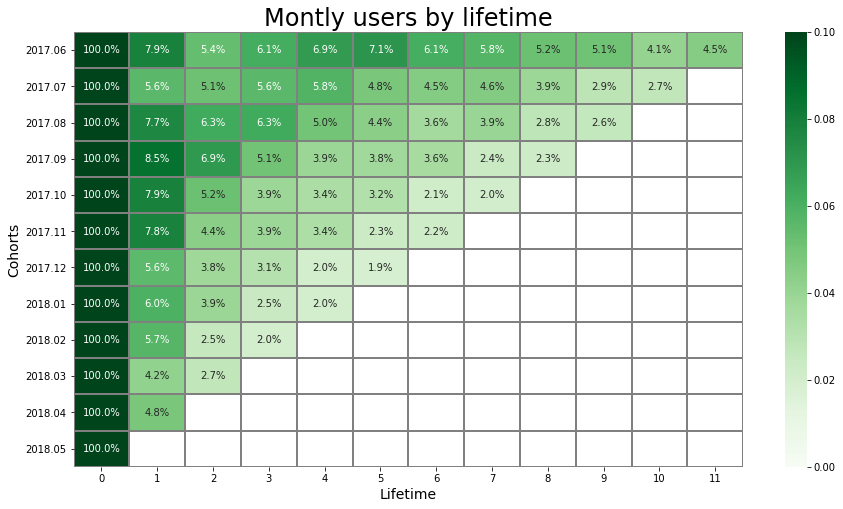

In [43]:
#Let's build a hotmap:
fig, ax = plt.subplots(figsize=(15, 8))

plt.title('Montly users by lifetime', fontsize=24)
    
sns.heatmap(cohorts_pivot_table, 
            annot= True,
            fmt = '.1%',
            linewidths = 1,
            linecolor = 'grey',
            vmin = 0,
            vmax = 0.1,
            cmap = 'Greens' 
           )
ax.set_ylabel('Cohorts', fontsize=14)    
ax.set_xlabel('Lifetime', fontsize=14)

**Conclusion:**
    
- Our data reveals that only a small fraction, not exceeding 9% of users, return to our service in subsequent months. Furthermore, this number consistently declines each month. This indicates that while we invest in acquiring new customers, a significant portion of them does not engage with us beyond their initial interaction. It's crucial for us to investigate the reasons behind this trend and address any issues that may have left users unsatisfied. 
- Retaining existing customers is often more cost-effective than acquiring new ones. In our next analysis, we will explore how many users have engaged with us on multiple occasions.

### Sales Metrics

#### When do people start making purchases?

In [44]:
# Group the 'orders' DataFrame by 'uid' and find the minimum 'buy_ts' (buy timestamp) for each user
orders_first = orders.groupby('uid').agg({'buy_ts':'min'})

# Rename the 'buy_ts' column to 'first_order' for clarity
orders_first = orders_first.rename(columns={'buy_ts':'first_order'})

# Round the 'first_order' date to the nearest day using the floor method
orders_first['first_order'] = orders_first['first_order'].dt.floor('1D')

In [45]:
# Select relevant columns ('device', 'uid', 'date', 'source_id') from the 'visits' DataFrame
visits_conversion = visits[['device', 'uid', 'date', 'source_id']]

# Sort the 'visits_conversion' DataFrame by the 'date' column in ascending order
visits_conversion = visits_conversion.sort_values(by='date')

# Group the data by 'uid' and aggregate information for the first session of each user
visits_conversion = (
    visits_conversion.
    groupby('uid').
    agg({'date':'min', 'device':'first', 'source_id':'first'}) 
)

# Rename the 'date' column to 'first_session' for clarity
visits_conversion = visits_conversion.rename(columns={'date':'first_session'})


In [46]:
#Let's combine the Orders_First and Visits_First tables
conversion_first = orders_first.merge(visits_conversion, on= 'uid', how = 'left')

In [47]:
# Let's calculate the conversion time
conversion_first['term'] = (
    ((conversion_first['first_order'] - conversion_first['first_session']) 
    / np.timedelta64(1,'D')).astype('int')
)

##### Average conversion

In [48]:
# Describe the 'term' column of the 'conversion_first' DataFrame, which provides summary statistics
conversion_first['term'].describe()

count   36523.00
mean       16.90
std        47.07
min         0.00
25%         0.00
50%         0.00
75%         2.00
max       363.00
Name: term, dtype: float64

In [49]:
avg_conversion = conversion_first['term'].median()
print('Average conversion is {:.1f} days.'.format(avg_conversion))

Average conversion is 0.0 days.


##### Distribution of conversions by term

In [50]:
# Determining the type of conversion
def type_conversion(term):
    if term == 0:
        return 'Conversion 0-day'
    if term <=7:
        return 'Conversion 7-day'
    if term <=14:
        return 'Conversion 14-day'
    if term <=30:
        return 'Conversion 30-day'
    else:
        return 'Conversion > 30-day'

In [51]:
# Calculate the type of conversion for each user and create a new column 'type_conversion'
conversion_first['type_conversion'] = conversion_first['term'].apply(type_conversion)

# Group the 'conversion_first' DataFrame by 'type_conversion' and count the occurrences of each type
conversion_share = conversion_first.groupby('type_conversion').agg({'type_conversion':'count'})

# Rename the column 'type_conversion' to 'count' for clarity
conversion_share = conversion_share.rename(columns={'type_conversion':'count'})

# Reset the index to make 'type_conversion' a regular column
conversion_share = conversion_share.reset_index()

# Calculate the ratio (share) of each type of conversion as a percentage of the total
conversion_share['ratio'] = conversion_share['count'] / conversion_share['count'].sum() * 100


conversion_share

,type_conversion,count,ratio
0,Conversion 0-day,25039,68.56
1,Conversion 14-day,974,2.67
2,Conversion 30-day,1279,3.50
3,Conversion 7-day,4297,11.77
4,Conversion > 30-day,4934,13.51


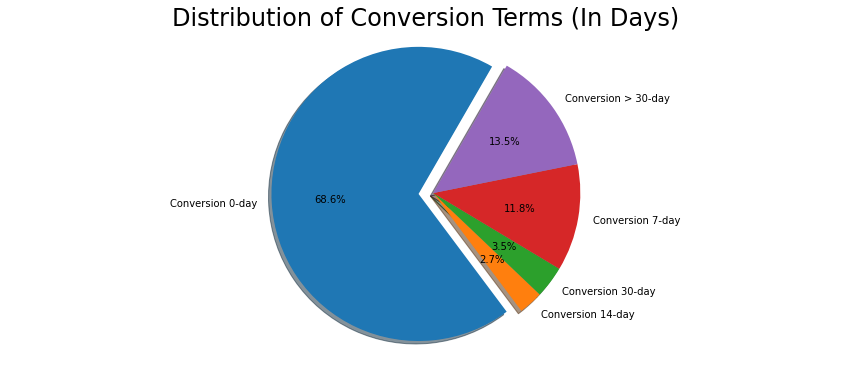

In [52]:
# Create a pie chart to visualize the distribution of conversion types
fig, ax1 = plt.subplots(figsize=(15, 6))

# Define the 'explode' parameter to emphasize a portion of the pie (optional)
explode = (0.1, 0, 0, 0, 0)

# Create the pie chart with labels, percentages, shadow, and starting angle
ax1.pie(conversion_share['ratio'],
        explode=explode,
        labels=conversion_share['type_conversion'],
        autopct='%1.1f%%',
        shadow=True,
        startangle=60)

# Set the aspect ratio to ensure the pie is drawn as a circle
ax1.axis('equal')

# Set the title of the pie chart
ax1.set_title('Distribution of Conversion Terms (In Days)', fontsize=24)

# Display the pie chart
plt.show()

**Conclusion:**

As we can see from the pie chart above, 68.6% of orders are made on the day of the first visit to the site. 11.8% of users make the order within a week after the first visit. 13.5% make their first order more than a month after the first visit.

##### Distribution of conversions by source

In [53]:
conversion_by_source = conversion_first.groupby('source_id').agg({'term':['mean','count']}).reset_index()
conversion_by_source.columns = ['source_id','mean','count']
conversion_by_source['ratio_count'] = ( 
    conversion_by_source['count'] / conversion_by_source['count'].sum()*100    
)

In [54]:
def create_label(item):
    text = 'Source ' + str(int(item['source_id']))
    return text

conversion_by_source['label'] = conversion_by_source.apply(create_label,axis=1)

In [55]:
conversion_by_source = conversion_by_source[conversion_by_source['mean'] != 0].reset_index()

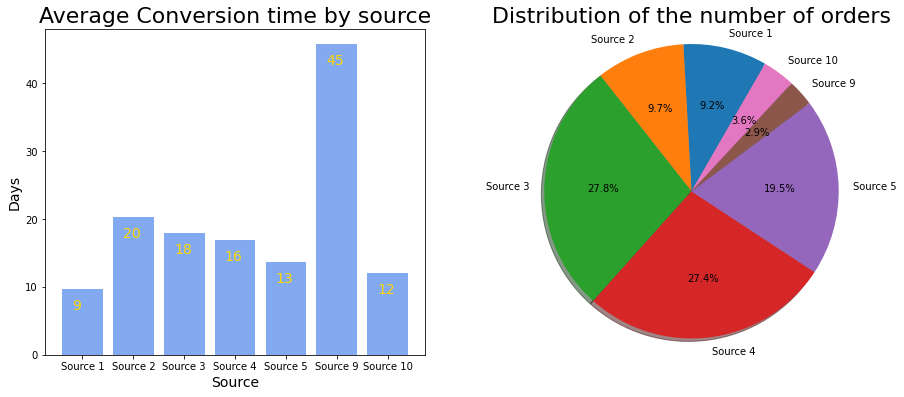

In [56]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1 = plt.subplot(121)

n = len(conversion_by_source['label'])
ind = np.arange(n) 

res = plt.bar(ind, conversion_by_source['mean'],
        align='center',
        alpha=0.8, 
        color='cornflowerblue')

plt.xlabel('Source', fontsize=14)
plt.ylabel('Days', fontsize=14)
plt.title('Average Conversion time by source', fontsize=22)
plt.xticks(ind, conversion_by_source['label'])
for idx,i in enumerate(ax1.patches):
    ax1.text(i.get_x() + .2, 
             i.get_height() - 3, 
             int(conversion_by_source['mean'][idx]), 
             fontsize=14,color='gold')
   
ax2 = plt.subplot(122)
res = ax2.pie(conversion_by_source['ratio_count'],
#         explode = explode ,
        labels  = conversion_by_source['label'],
        autopct = '%1.1f%%',
        shadow  = True,
        startangle = 60)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Distribution of the number of orders', fontsize=22)

plt.show()

**Conclusion:**

In summary, there are no orders from Sources 6,7,8. A very long conversion period at source 9. Probably because of such a long period, only 2.9% of orders come from source 9. The most popular sources are 3 and 4, and their conversion time is 18 and 16 days, respectively. Best conversion time from 1 source, 9 days.

#### How many orders do they make during specific time periods?

##### Distribution of the number of orders by cohorts

In [57]:
orders_all = orders.merge(visits_conversion, on= 'uid', how = 'left')
orders_all['actual_date'] = orders_all['buy_ts'].dt.floor('1D')

In [58]:
# Step 1: Calculate the first day of the first session
orders_all['first_day_of_first_session'] = (
    pd.to_datetime(orders_all['first_session'], unit='d')
    -
    pd.to_timedelta(orders_all['first_session'].dt.day-1, unit = 'd')
)

# Step 2: Group orders by the first day of the first session and source_id
orders_per_cohort = (
    orders_all.
    groupby(['first_day_of_first_session', 'source_id'],
           as_index=False).agg({'device':'count'})
)

# Step 3: Apply a label to each cohort using the create_label function
orders_per_cohort['label'] = orders_per_cohort.apply(create_label, axis=1)

# Step 4: Rename the 'device' column to 'count_orders' for clarity
orders_per_cohort = orders_per_cohort.rename(columns = {'device':'count_orders'})

In [59]:
# Step 1: Calculate the total count of orders in each cohort
orders_cohort_all = orders_per_cohort.groupby('first_day_of_first_session').agg({'count_orders':'sum'})

# Step 2: Rename the 'count_orders' column to 'count_orders_all' for clarity
orders_cohort_all = orders_cohort_all.rename(columns={'count_orders':'count_orders_all'})

# Step 3: Merge the total count of orders back into the 'orders_per_cohort' DataFrame
orders_per_cohort = pd.merge(orders_per_cohort, orders_cohort_all, on='first_day_of_first_session')

# Step 4: Calculate the ratio of orders from each source in each cohort
orders_per_cohort['ratio'] = ( 
    orders_per_cohort['count_orders'] / orders_per_cohort['count_orders_all']
)

In [60]:
# Step 1: Convert the 'first_day_of_first_session' column to a string in the format 'YYYY.MM'
# Convert the 'first_day_of_first_session' column to datetime
orders_per_cohort['first_day_of_first_session'] = pd.to_datetime(orders_per_cohort['first_day_of_first_session'])
orders_per_cohort['first_day_of_first_session'] = orders_per_cohort['first_day_of_first_session'].dt.strftime('%Y.%m')


# Step 2: Create a pivot table to reshape the data for easy analysis
orders_per_cohort_pivot_table = orders_per_cohort.pivot_table(
    index = 'first_day_of_first_session',  # Rows will represent the cohort's first session month
    columns = 'label',  # Columns will represent the source labels
    values = 'ratio',  # Values will be the ratio of orders for each source in each cohort
    aggfunc = 'max'  # Aggregate function to calculate the maximum ratio value
)

Text(0.5, 51.0, 'Source')

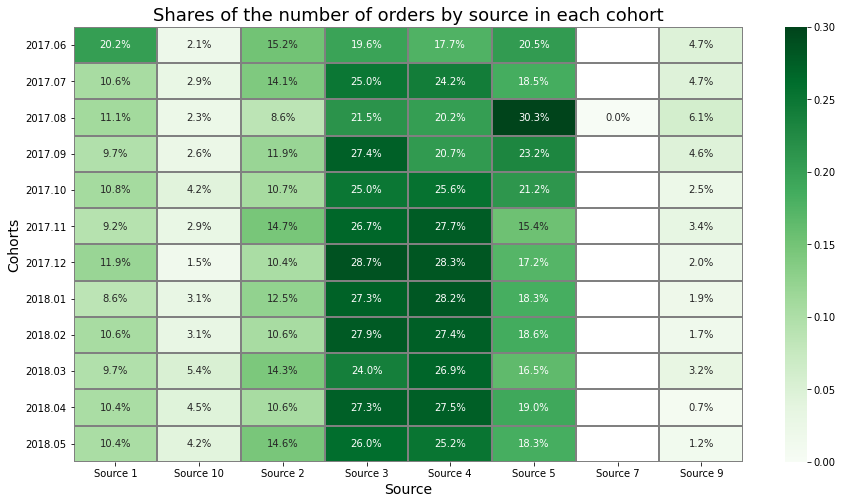

In [61]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.title('Shares of the number of orders by source in each cohort', fontsize=18)
    
sns.heatmap(orders_per_cohort_pivot_table, 
            annot= True,
            fmt = '.1%',
            linewidths = 1,
            linecolor = 'grey',
            vmin = 0,
            vmax = 0.3,
            cmap = 'Greens',
            yticklabels = True,
           )
ax.set_ylabel('Cohorts', fontsize=14)   
ax.set_xlabel('Source', fontsize=14)

**Conclusion:**
- We see that the shares of each sources in different cohorts are approximately the same. However, there are exceptions:
   - The share of source 1 in the first cohort is two times higher than in other cohorts
   - The share of source 5 in the third cohort is noticeably higher than in others sources. 
- Source 3 dan source 4 have the highest share among other sources.
- Source 7 has no share, we can conclude this source is not effective to attract customers to come in the website.
- Overall, it can be concluded that the shares change from cohort to cohort, but not much.

#### The average purchase size.

##### The average size of purchase by cohort

In [62]:
# Step 1: Convert the 'first_day_of_first_session' column to a string in the format 'YYYY.MM'
orders_all['first_day_of_month_str'] = ( 
    orders_all['first_day_of_first_session'].dt.strftime('%Y.%m')
)

# Step 2: Calculate the mean revenue for each cohort
revenue_cohort = ( 
    orders_all.
    groupby(['first_day_of_month_str']).
    agg({'revenue':'mean'})
)

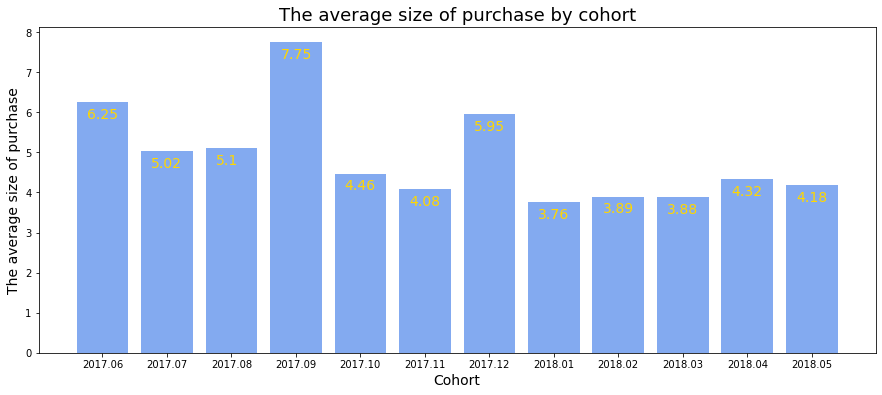

In [63]:
n = len(revenue_cohort['revenue'])
ind = np.arange(n) 

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, revenue_cohort['revenue'],
        align='center',
        alpha=0.8, 
        color='cornflowerblue')

plt.xlabel('Cohort', fontsize=14)
plt.ylabel('The average size of purchase', fontsize=14)
plt.title('The average size of purchase by cohort', fontsize=18)
plt.xticks(ind, revenue_cohort.index.values)
for idx,i in enumerate(ax.patches):
    ax.text(i.get_x()+.16, 
            i.get_height()-0.4, 
            float(int(revenue_cohort['revenue'][idx]*100)/100), 
            fontsize=14,color='gold')
plt.show()

**Conclusion:**

The chart illustrate that the average buy size ranges from 4.08 to 7.75. September 2017 has the highest average purchase price.

#### How much money do they contribute? (LTV)

##### Average profit per client.

In [64]:
ltv = orders_all.groupby('uid').agg({'revenue':'sum'}) 
ltv_avg = ltv.sum()[0] / len(ltv) 
print('Average profit per client ${:.1f}.'.format(ltv_avg))

Average profit per client $6.9.


##### Average profit per client by source.

In [65]:
# Sorting the 'orders_all' DataFrame by 'buy_ts' to ensure data consistency
orders_all = orders_all.sort_values(by='buy_ts')

# Grouping the data to determine the source of the first visit for each user
source_first = orders_all.groupby('uid').agg({'source_id':'first'})

# Renaming the 'source_id' column to 'source_id_first' for clarity
source_first = source_first.rename(columns={'source_id':'source_id_first'})

# Merging the 'source_first' DataFrame with the 'orders_all' DataFrame on the 'uid' column
orders_all = orders_all.merge(source_first, on='uid')

In [66]:
# Calculate total revenue for each user from each source
ltv_source_all = orders_all.groupby(['uid', 'source_id_first']).agg({'revenue':'sum'})

# Calculate the sum of revenue and count of users for each source
ltv_source = ( 
    ltv_source_all.
    groupby('source_id_first').
    agg({'revenue':['sum','count']})
    .reset_index()
)

# Rename columns for clarity
ltv_source.columns = ['source_id', 'total_revenue', 'user_count']

# Calculate the LTV per customer for each source
ltv_source['ltv_customer'] = ltv_source['total_revenue'] / ltv_source['user_count']

# Create labels for graph using the 'create_label' function
ltv_source['label'] = ltv_source.apply(create_label, axis=1)

# Remove records with 'Source 7' as it's considered an anomaly
ltv_source = ltv_source[ltv_source['label'] != 'Source 7'].reset_index()

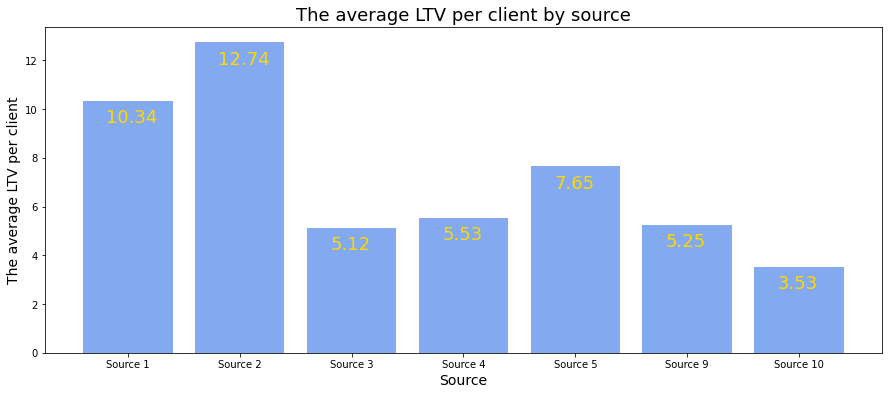

In [67]:
n = len(ltv_source['ltv_customer'])
ind = np.arange(n) 

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, ltv_source['ltv_customer'],
        align='center',
        alpha=0.8, 
        color='cornflowerblue')

plt.xlabel('Source', fontsize=14)
plt.ylabel('The average LTV per client', fontsize=14)
plt.title('The average LTV per client by source', fontsize=18)
plt.xticks(ind, ltv_source['label'])
for idx,i in enumerate(ax.patches):
    ax.text(i.get_x()+.21, 
            i.get_height()-0.9, 
            float(int(ltv_source['ltv_customer'][idx]*100)/100), 
            fontsize=18,color='gold')
plt.show()

**Conclusion:**

The chart illustrate that the largest LTVs are from sources 1 and 2. If the costs of attracting customers from these sources are profitable, then it is necessary to increase the number of orders from these sources. 

##### Average profit per client by cohort

In [68]:
# We find the first day of the month in which the current contact took place
orders_all['first_day_of_actual_order'] = (
    pd.to_datetime(orders_all['actual_date'], unit='d') 
    -
    pd.to_timedelta(orders_all['actual_date'].dt.day - 1, unit='d') 
)

In [69]:
# Ley's Find out how many months have passed between the current order and the first contacts
orders_all['cohort_lifetime'] = (
    round(((orders_all['first_day_of_actual_order'] 
            -
            orders_all['first_day_of_first_session']) / 
           np.timedelta64(1,'M'))).astype(int)
)


In [70]:
# calculating the number of unique users in each cohort every month
cohorts_ltv = (
    orders_all.query('actual_date != "2018-06-01"').
    groupby(['first_day_of_first_session','cohort_lifetime']).
    agg({'revenue':['sum','count']}).
    reset_index().reset_index()
)
cohorts_ltv.columns = ['index',
                       'first_day_of_first_session',
                       'cohort_lifetime',
                       'revenue',
                       'count_orders']
# counting the number of clients in each cohort
cohorts_ltv_0 = (
    orders_all.
    groupby('first_day_of_first_session').
    agg({'uid':'nunique'}).reset_index()
)
cohorts_ltv_0 = cohorts_ltv_0.rename(columns = {'uid':'count_orders_all'})
cohorts_ltv = cohorts_ltv.merge(cohorts_ltv_0, on = 'first_day_of_first_session')

In [71]:
# Let's calculate the total amount of purchases in each cohort
cohorts_cumsum = ( 
    cohorts_ltv.
    groupby('first_day_of_first_session').
    agg({'revenue':'cumsum'}).
    reset_index()
)
cohorts_cumsum = cohorts_cumsum.rename(columns = {'revenue':'revenue_all'})
cohorts_ltv = cohorts_ltv.merge(cohorts_cumsum, on = 'index')
cohorts_ltv['revenue_per_user'] = cohorts_ltv['revenue_all']/cohorts_ltv['count_orders_all']
cohorts_ltv = cohorts_ltv[cohorts_ltv['first_day_of_first_session'] != '2018-06-01']
cohorts_ltv['first_day_of_first_session_str'] = ( 
    cohorts_ltv['first_day_of_first_session'].dt.strftime('%Y.%m')
)

In [72]:
# Let's create a pivot table with LTV information for each cohort
cohorts_ltv_pivot_table = cohorts_ltv.pivot_table(index = 'first_day_of_first_session_str',
                                              columns = 'cohort_lifetime',
                                              values = 'revenue_per_user',
                                              aggfunc = 'sum')

Text(0.5, 51.0, 'Cohort Lifetime')

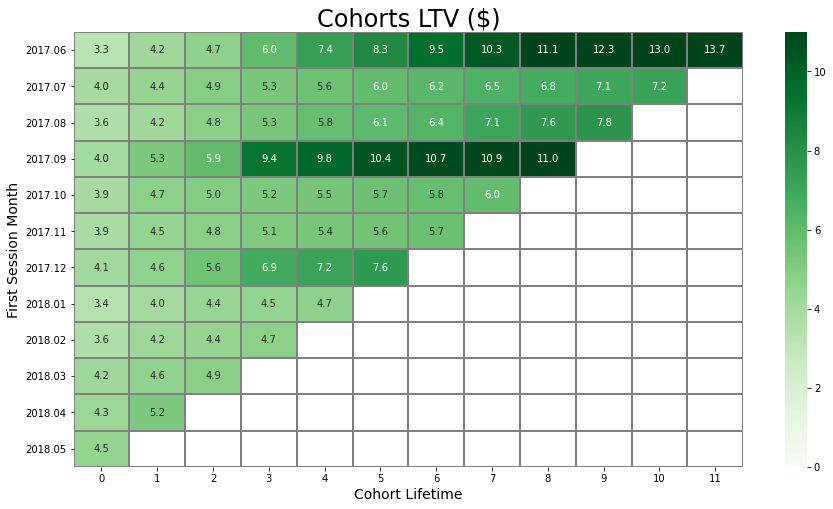

In [73]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.title('Cohorts LTV ($)', fontsize=24)
    
sns.heatmap(cohorts_ltv_pivot_table, 
            annot= True,
            fmt = '.1f',
            linewidths = 1,
            linecolor = 'grey',
            vmin = 0,
            vmax = 11,
            cmap = 'Greens' 
           )
ax.set_ylabel('First Session Month', fontsize=14)    
ax.set_xlabel('Cohort Lifetime', fontsize=14)

**Conclusion:**

From the cohort LTV chart, we can see that not all cohorts bring the same profit per client. 
- The most profitable were the first 4 cohorts.
- On average, each customer from the first cohort brought 13.7 dollars in revenue over their eleven-month lifetime. 
- The most profitable were the first 4 cohorts. 
- There is also an unexpectedly sharp rise in LTV in the fourth cohort in the fourth month from 5.9 to 9.4.

### Marketing

#### How much money is spent?

##### How much was spent on each source?

In [74]:
costs_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
costs_source['label'] = costs_source.apply(create_label, axis=1)

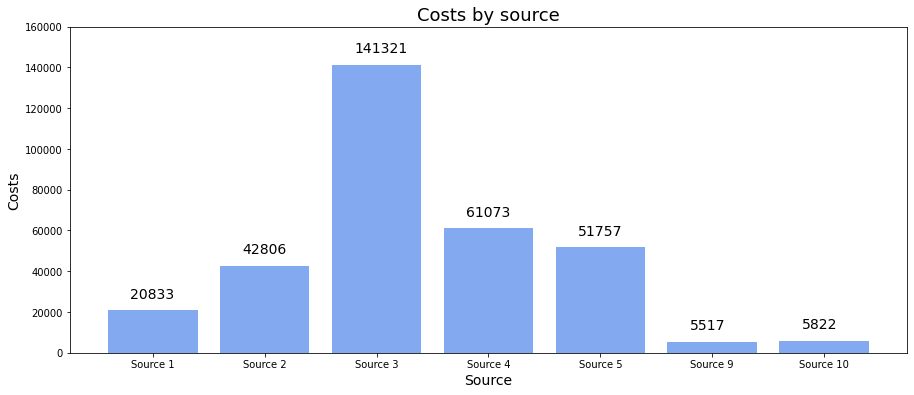

In [75]:
# create a plot
n = len(costs_source['costs'])
ind = np.arange(n) 

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, costs_source['costs'],
        align='center',
        alpha=0.8, 
        color='cornflowerblue')

plt.xlabel('Source', fontsize=14)
plt.ylabel('Costs', fontsize=14)
plt.title('Costs by source', fontsize=18)
plt.xticks(ind, costs_source['label'] )
ax.set_ylim([0, 160000])
for idx,i in enumerate(ax.patches):
    ax.text(i.get_x()+.2, 
            i.get_height() + 6000, 
            int(costs_source['costs'][idx]), 
            fontsize=14,color='black')
plt.show()

**Conclusion:**

As we can see, the largest cost comes from Source 3, which arearound 2.5 times more than for Source 4, however, as we determined earlier, Sources 3 and 4 give approximately the same number of share number of orders. Obviously, the advertising budget should be reallocated between Sources 3 and 4.

#### What is the customer acquisition cost

##### What is the customer acquisition cost for each source?

In [76]:
# Let's count the number of clients from each source, we will exclude 
source_number_buyers = orders_all.groupby('source_id', as_index = False).agg({'uid':'nunique'})
costs_source = costs_source.merge(source_number_buyers, on = 'source_id')
costs_source = costs_source.rename(columns = {'uid':'count_buyers'})

In [77]:
#Let's count CAC by source
costs_source['cac'] = costs_source['costs'] / costs_source['count_buyers']

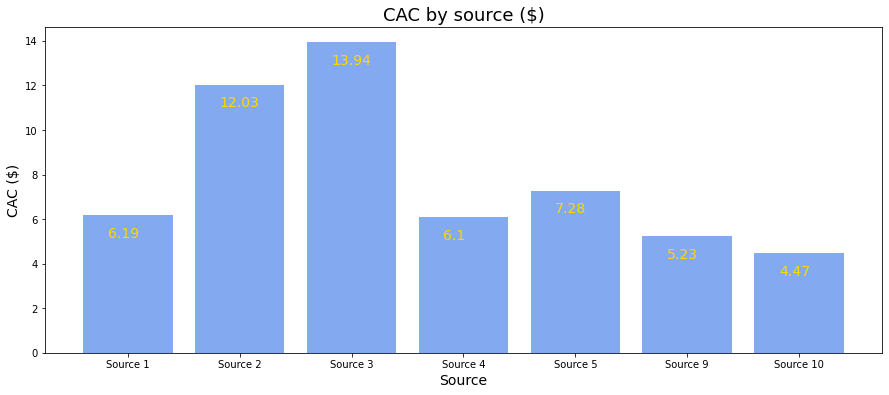

In [78]:
n = len(costs_source['cac'])
ind = np.arange(n) 

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, costs_source['cac'],
        align='center',
        alpha=0.8, 
        color='cornflowerblue')


plt.xlabel('Source', fontsize=14)
plt.ylabel('CAC ($)', fontsize=14)
plt.title('CAC by source ($)', fontsize=18)
plt.xticks(ind, costs_source['label'] )
for idx,i in enumerate(ax.patches):
    ax.text(i.get_x()+.22, 
            i.get_height() - 1 , 
            float(int(costs_source['cac'][idx]*100)/100), 
            fontsize=14,color='gold')
plt.show()

**In conclusion**, it's evident that Sources 2 and 3 incur the highest customer acquisition costs. 

While Source 2 seems to justify these costs due to a substantial lifetime value (LTV), Source 3 presents a concern as its LTV is notably low despite the significantly high cost of acquiring new customers. 

##### The cost of attracting customers by cohort.

In [79]:
# Finding the first day of the month
costs['first_day_of_first_session'] = (
    pd.to_datetime(costs['dt'], unit='d') 
    -
    pd.to_timedelta(costs['dt'].dt.day - 1, unit='d') 
)

costs_month = ( 
    costs.
    groupby('first_day_of_first_session', as_index = False).
    agg({'costs':'sum'})
)

In [80]:
costs_month = costs_month.merge(cohorts_ltv_0, on = 'first_day_of_first_session')
#Let's calculate CAC by cohorts
costs_month['cac'] = costs_month['costs'] / costs_month['count_orders_all'] 
costs_month['first_month_str']= ( 
    costs_month['first_day_of_first_session'].dt.strftime('%m.%Y')
)

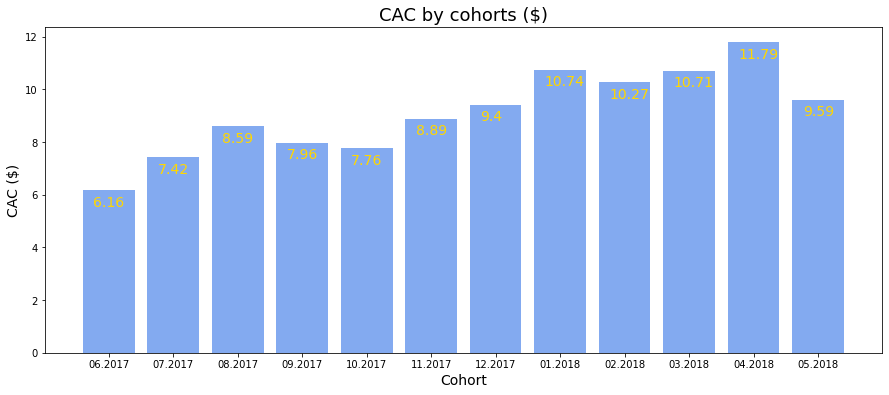

In [81]:
n = len(costs_month['cac'])
ind = np.arange(n) 

fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(ind, costs_month['cac'],
        align='center',
        alpha=0.8, 
        color='cornflowerblue')

plt.xlabel('Cohort', fontsize=14)
plt.ylabel('CAC ($)', fontsize=14)
plt.title('CAC by cohorts ($)', fontsize=18)
plt.xticks(ind, costs_month['first_month_str'])
for idx,i in enumerate(ax.patches):
    ax.text(i.get_x()+.16, 
            i.get_height()-0.6, 
            float(int(costs_month['cac'][idx]*100)/100), 
            fontsize=14,color='gold')
plt.show()

**Conclusion:**

As observed, the costs increase with each cohort. It's worth noting that some customers make their first purchase more than 30 days after their initial visit. Consequently, the costs in cohorts 04.2018 and 05.2018 are expected to decrease over time.

#### Assessment of return on investment in customer acquisition. (ROI)

In [82]:
# Revenue from customers from each cohort.
cohorts_revenue = ( 
    orders_all.
    groupby('first_day_of_first_session', as_index = False).
    agg({'revenue':'sum'})
)

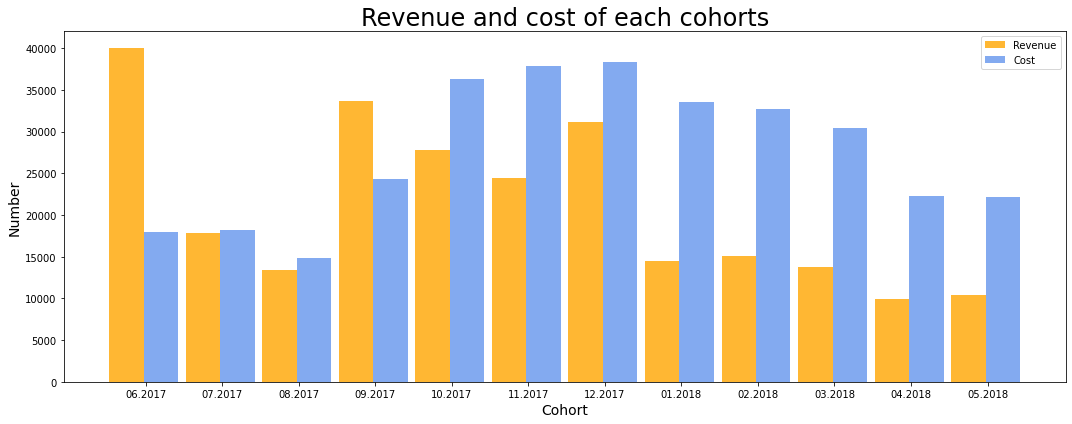

In [83]:
# one chart with two columns per cohorts / revenue + cost
all_cohorts_dict = list(costs_month['first_month_str'].tolist()) 
n_groups = len(all_cohorts_dict)

# create plot
fig, ax = plt.subplots(figsize=(15, 6))

index = np.arange(n_groups)
bar_width = 0.45
opacity = 0.8
rects1 = plt.bar(index, cohorts_revenue['revenue'], bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Revenue')

rects2 = plt.bar(index + bar_width, costs_month['costs'], bar_width,
                 alpha=opacity,
                 color='cornflowerblue',
                 label='Cost')

plt.xlabel('Cohort', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.title('Revenue and cost of each cohorts', fontsize=24)

plt.xticks(index + bar_width-0.2, all_cohorts_dict)
plt.legend()

plt.tight_layout()
plt.show()

**Conclusion:**

The histogram clearly indicates that revenue surpasses costs in only 2 cohorts. This highlights the need to identify and address any problem areas, making necessary adjustments for improvement.

##### ROMI by cohort

In [84]:
cohorts_romi = (
    cohorts_ltv.
    merge(costs_month[['first_day_of_first_session','costs']],
          on = 'first_day_of_first_session')
)
cohorts_romi['romi'] = cohorts_romi['revenue_all'] / cohorts_romi['costs']

In [85]:
# Let's create a pivot table with ROMI information for each cohort
cohorts_romi_pivot_table = cohorts_romi.pivot_table(index = 'first_day_of_first_session_str',
                                                    columns = 'cohort_lifetime',
                                                    values = 'romi',
                                                    aggfunc = 'sum')

Text(0.5, 51.0, 'Cohort Lifetime')

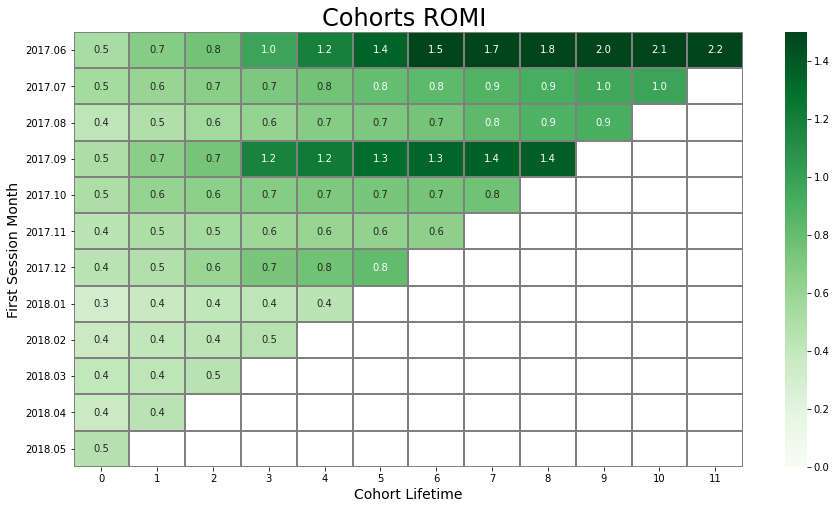

In [86]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.title('Cohorts ROMI ', fontsize=24)
    
sns.heatmap(cohorts_romi_pivot_table, 
            annot= True,
            fmt = '.1f',
            linewidths = 1,
            linecolor = 'grey',
            vmin = 0,
            vmax = 1.5,
            cmap = 'Greens' 
           )
ax.set_ylabel('First Session Month', fontsize=14)    
ax.set_xlabel('Cohort Lifetime', fontsize=14)

**Conclusion:**

The graph highlights a concerning trend in profitability. The investments made in promotions are struggling to yield positive returns. Only in three cohorts (1, 2, and 4), revenue exceeded costs.

##### ROMI by source

In [87]:
source_romi = orders_all[['revenue',
                          'first_session',
                          'source_id',
                          'actual_date',
                          'first_day_of_first_session',
                          'first_day_of_actual_order']]

In [88]:
# Let's find out how many months have passed between the current order and the first contacts
source_romi['cohort_lifetime'] = (
    round(
        (((orders_all['first_day_of_actual_order'] 
           -
           orders_all['first_day_of_first_session']) / 
          np.timedelta64(1,'M')))).astype(int)
)

/tmp/ipykernel_26/4109453489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_romi['cohort_lifetime'] = (


In [89]:
source_lifetime = (
    source_romi.
    groupby(['source_id','cohort_lifetime'],as_index = False).
    agg({'revenue':'sum'}).reset_index()
)

In [90]:
source_cumsum = ( 
    source_lifetime.
    groupby('source_id').
    agg({'revenue':'cumsum'}).reset_index()
)
source_cumsum = source_cumsum.rename(columns = {'revenue':'revenue_source'})

In [91]:
source_lifetime = source_lifetime.merge(source_cumsum, on = 'index')
source_cost = costs.groupby('source_id',as_index = False).agg({'costs':'sum'})
source_lifetime = source_lifetime.merge(source_cost, on = 'source_id')

source_lifetime['romi'] = source_lifetime['revenue_source'] / source_lifetime['costs']
source_lifetime['label'] = source_lifetime.apply(create_label,axis=1)

In [92]:
source_lifetime_pivot_table = source_lifetime.pivot_table(index = 'label',
                                                          columns = 'cohort_lifetime',
                                                          values = 'romi',
                                                          aggfunc = 'sum')

Text(0.5, 51.0, 'Cohort Lifetime')

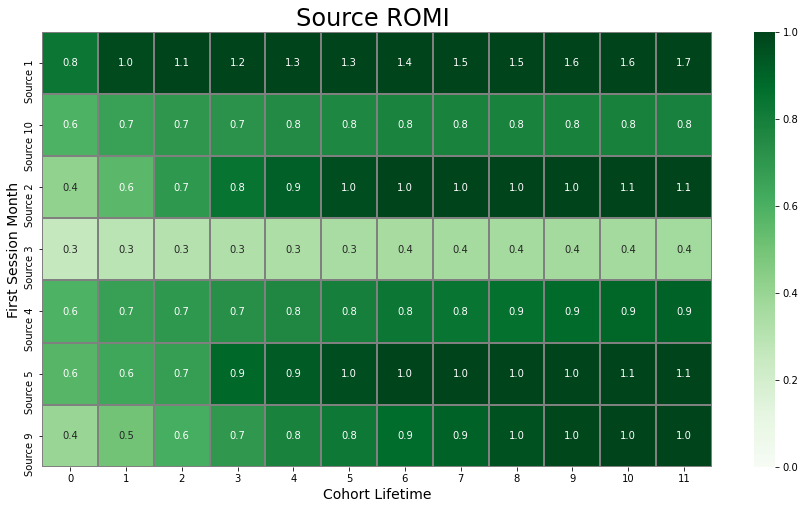

In [93]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.title('Source ROMI ', fontsize=24)
    
sns.heatmap(source_lifetime_pivot_table, 
            annot= True,
            fmt = '.1f',
            linewidths = 1,
            linecolor = 'grey',
            vmin = 0,
            vmax = 1,
            cmap = 'Greens' 
           )
ax.set_ylabel('First Session Month', fontsize=14)    
ax.set_xlabel('Cohort Lifetime', fontsize=14)

**Conclusion:**

In the earlier part, we figured out that most of our customer acquisition efforts weren't paying off. Now, in this section, we've got some clear findings:

- Sources to Drop: We need to stop investing in Sources 10, 3, and 4 ASAP. Why? Well, it's costing us more to get customers from these sources than what they're bringing in as profit.

- Source 9 Dilemma: It's almost breaking even, but unless we find a way to make our customers spend more (LTV) or spend less to acquire them (CAC), we might want to think about cutting ties with it too.

- Star Performer: Source 1 is the star here. If there's a chance to get more customers from it, we should definitely go for it.

- Source 3 Mystery: Source 3 is a bit of a puzzle. We're spending a lot to get customers from there, but it's not paying off. Interestingly, if we exclude Source 3 from the picture, most of our cohorts would actually be profitable.

So, overall, things don't look great financially, and many of our customer groups aren't making money. But without Source 3's big expenses, it's a different story.

## Overall Conclusion

1. We have some promising sources:
   - Source 1: The most promising channel with excellent ROMI and Conversion. We need to work on increasing the number of clients from this resource.
   - Source 2, 5: 	A good channel with good ROMI. We need to work on increasing LTV and reducing CAC.
   - Source 9: It's almost breaking even, but unless we find a way to make our customers spend more (LTV) or spend less to acquire them (CAC), we might want to think about cutting ties with it too.
2. But there are some sources need more attention:
   - Source 3: The resource with the worst indicators. We need to urgently stop investment in this Source, and also to figure out what's the reason for such high costs and small sales.
   - Source 4, 9, and 10 : The resource is unprofitable. We need to increase LTV and lower CAC, and make some test for a certain period. If this fails, we need to stop investing in this source.